In [1]:
import h5py
import os
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
#%%

In [ ]:
new_root = './data/'
img_fname = 'validation.h5'
aux_fname = 'validation_geo.h5'

# sample indices to visualize
start_idx = 10020
end_idx = 10024

sen1_data shape: (24119, 32, 32, 8)
Sample coordinate: [5.50495858e+05 4.18305443e+06 1.83500000e+03 2.55000000e+03
 1.80000000e+03 2.55000000e+03]
Sample epsg: [32610]
tfw: [5.50335858e+05 1.00000000e+01 0.00000000e+00 4.18321443e+06
 0.00000000e+00 1.00000000e+01]


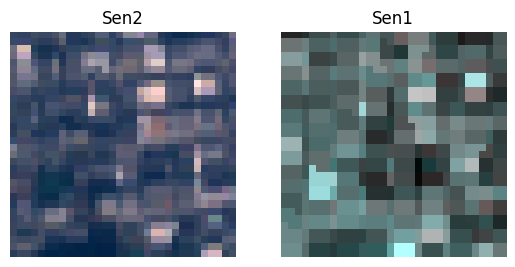

In [ ]:
h5_file = os.path.join(new_root,img_fname)

with h5py.File(h5_file, 'r') as fid1:
    sen1_shape = fid1['sen1'].shape
    print("sen1_data shape:", sen1_shape)

with h5py.File(h5_file, 'r') as fid1:
    sen1_data = np.array(fid1['sen1'][start_idx:end_idx])  # (N, patchSize, patchSize, 8)
    sen2_data = np.array(fid1['sen2'][start_idx:end_idx])
    label_data = np.array(fid1['label'][start_idx:end_idx])

h5_file_aux = os.path.join(new_root,aux_fname)

with h5py.File(h5_file_aux, 'r') as fid1:
    tfw_new = np.array(fid1['tfw'][start_idx:end_idx])
    epsg_new = np.array(fid1['epsg'][start_idx:end_idx])
    coord = np.array(fid1['coord'][start_idx:end_idx])

#%%
print("Sample coordinate:", coord[0])
print("Sample epsg:", epsg_new[0])
print("tfw:", tfw_new[0])
# plt.figure(figsize=(6, 6))
plt.subplot(1,2,1)
rgb = sen2_data[0, :, :, 0:3] # BGR
rgb = rgb[:, :, ::-1]  # BGR to RGB
rgb_norm = (rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb))
plt.imshow(rgb_norm)
plt.axis('off')
plt.title('Sen2')

plt.subplot(1,2,2)
s1 = np.stack([sen2_data[0, :, :, 4], sen2_data[0, :, :, 5], sen2_data[0, :, :, 5]], axis=2)  # false color
s1_norm = (s1 - np.min(s1)) / (np.max(s1) - np.min(s1))
plt.imshow(s1_norm)
plt.title('Sen1')
plt.axis('off')

plt.show()

In [12]:
for sample_idx in range(start_idx, end_idx):
    print(f"Saving sample {sample_idx} ...")

    sample_sen1 = np.transpose(sen1_data[sample_idx - start_idx], (2, 0, 1))
    sample_sen2 = np.transpose(sen2_data[sample_idx - start_idx], (2, 0, 1))

    origin_x = tfw_new[sample_idx - start_idx, 0]
    pixel_width = tfw_new[sample_idx - start_idx, 1]
    origin_y = tfw_new[sample_idx - start_idx, 3]
    pixel_height = tfw_new[sample_idx - start_idx, 5]
    transform = from_origin(origin_x, origin_y, pixel_width, pixel_height)
    epsg_code = int(epsg_new[sample_idx - start_idx, 0])

    # write sen1
    sen1_outfile = os.path.join(new_root, f'sen1_patch_{sample_idx}.tif')
    with rasterio.open(
        sen1_outfile, 'w',
        driver='GTiff',
        height=sample_sen1.shape[1],
        width=sample_sen1.shape[2],
        count=sample_sen1.shape[0],
        dtype=sample_sen1.dtype,
        crs=f'EPSG:{epsg_code}',
        transform=transform
    ) as dst:
        dst.write(sample_sen1)

    # write sen2
    sen2_outfile = os.path.join(new_root, f'sen2_patch_{sample_idx}.tif')
    with rasterio.open(
        sen2_outfile, 'w',
        driver='GTiff',
        height=sample_sen2.shape[1],
        width=sample_sen2.shape[2],
        count=sample_sen2.shape[0],
        dtype=sample_sen2.dtype,
        crs=f'EPSG:{epsg_code}',
        transform=transform
    ) as dst:
        dst.write(sample_sen2)

    # # Check if the written files have projection information
    # print(f'Checking projection of {sen1_outfile}:')
    # os.system(f'gdalinfo {sen1_outfile} | grep "Coordinate System is"')
    # print(f'Checking projection of {sen2_outfile}:')
    # os.system(f'gdalinfo {sen2_outfile} | grep "Coordinate System is"')

Saving sample 10020 ...
Saving sample 10021 ...
Saving sample 10022 ...
Saving sample 10023 ...
